In [342]:
#%% Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from nets_predict.classes.hmm import HiddenMarkovModelClass
from nets_predict.classes.partial_correlation import PartialCorrelationClass

HMMClass = HiddenMarkovModelClass()
PartialCorrClass = PartialCorrelationClass()


In [343]:
# set parameters for script
n_chunk = 12
n_ICs = 25
n_edge = int((n_ICs * (n_ICs - 1))/2)
n_states = 8

In [344]:
# set project directories
proj_dir = '/gpfs3/well/win-fmrib-analysis/users/psz102/nets_project/nets_predict'
load_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

# decide which featured to examine
feature_prediction_dict = dict()
feature_prediction_dict['actual'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['static'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True.npz")
feature_prediction_dict['fc'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_fc_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['pc'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_pc_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['all'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_all_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['means'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_means_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['tpms_ss'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_tpms_ss_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['tpms_ss_only'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_tpms_ss_only_states_{n_states}_model_mean_True.npz")

In [347]:
# load ground truth matrix
ground_truth_dir = f"{proj_dir}/results/ICA_{n_ICs}/ground_truth"
ground_truth_matrix = np.load(f"{ground_truth_dir}/ground_truth_mean_4_sessions.npy")

# extract upper diagonal (excluding main diagonal) 
ground_truth_icov_reshape = PartialCorrClass.extract_upper_off_main_diag(ground_truth_matrix)

# take mean ground truth across subjects
ground_truth_icov_reshape_mean = np.mean(ground_truth_icov_reshape,axis=0)


In [350]:
static_dir = f"{proj_dir}/results/ICA_{n_ICs}/static"
partial_correlations_chunk = np.load(f"{static_dir}/partial_correlations_{n_chunk}_chunks.npy")
print(partial_correlations_chunk.shape)
partial_correlations_chunk_flatten = PartialCorrClass.extract_upper_off_main_diag(partial_correlations_chunk)
print(partial_correlations_chunk_flatten.shape)

(1003, 12, 25, 25)
(1003, 12, 300)


In [362]:
################## WE FIRST LOOK AT PLOTTING STATICS ##################

In [370]:
################## WE NOW INTRODUCE DYNAMICS ##################

# note how many dynamic features are being used and print what they are
n_feat_type = len(feature_prediction_dict) 
print(n_feat_type)
print(*feature_prediction_dict)

/tmp/ipykernel_190969/2885560549.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('twilight_shifted')


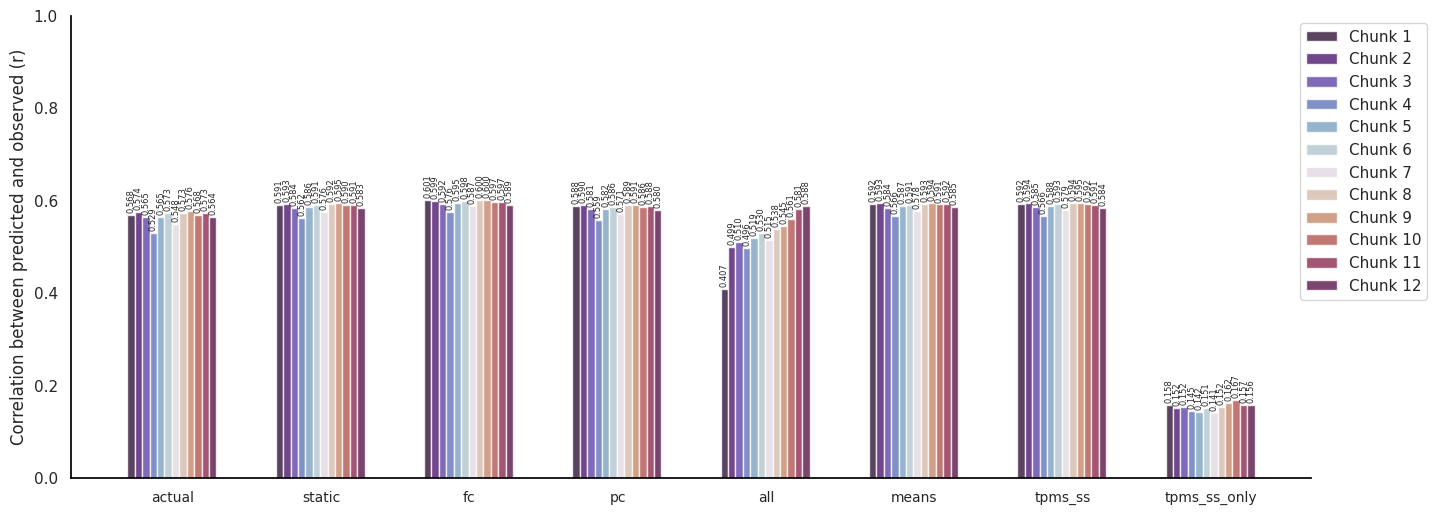

In [398]:
##################### Plot bar chart of accuracies across HMM feature groups ########################


# let's combine the prediction accuracies for each hmm features into a combined array
hmm_features_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, value in feature_prediction_dict.items():
    hmm_features_accuracy[feat_num,:,:] = value['accuracy_per_edge']
    labels.append(key) # create labels for plot
    feat_num += 1
    
    
print(*feature_prediction_dict['static'])

# if we want to remove nan subjects see commented code at end of script

# Here we split up the accuracy of the chunks for using partial correlations to predict partial correlations
# Create a colormap with a smooth transition of colors
cmap = cm.get_cmap('twilight_shifted')

# Define the number of colors needed
num_colors = n_chunk

# Get a list of colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a new figure for the grouped bar chart with a larger size
fig, ax = plt.subplots(figsize=(16, 6))

# Set bar width, group offset, and x-positions of bars
x = np.arange(len(labels))
if n_chunk == 4:
    bar_width = 0.15
    group_offset = (len(labels)) * bar_width
elif n_chunk == 12:
    bar_width = 0.05
    group_offset = (len(labels) + 8) * bar_width

# Iterate over the traits
for i in range(n_chunk):
    chunk_plot = hmm_features_accuracy[:,i,:]

    # Calculate the mean values for each bar
    means = np.mean(chunk_plot, axis=1)

    # Calculate the x-axis positions for the bars within a group
    x_grouped = x + (i - 2) * bar_width - group_offset + 0.37

    # Plot the bars within a group
    bars = ax.bar(x_grouped, means, width=bar_width, color=colors[i % num_colors], alpha=0.8)

    # Add text labels on top of each bar with decreased fontsize
    for bar in bars:
        height = bar.get_height()
        if n_chunk == 4:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=90)
        elif n_chunk == 12:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=6, rotation=90)

# Set the y-axis label
ax.set_ylabel('Correlation between predicted and observed (r)', fontsize=12)

# Set the x-axis tick labels and move them to the left
if n_chunk == 4:
    ax.set_xticks(x - 0.9)
elif n_chunk == 12:
    ax.set_xticks(x - 0.25)

ax.set_xticklabels(labels, fontsize=10)

# Add a legend for the eight bars
ax.legend(labels=['Chunk ' + str(i+1) for i in range(n_chunk)], loc='upper right', bbox_to_anchor=(1.1, 1.0))

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the y-axis limits to range from 0.7 to 1
ax.set_ylim(0, 1)
#ax.set_ylim(np.nanmin(means)-0.05, np.nanmax(means)+0.1)

# Remove the grid
ax.grid(False)

# Set the color of the x and y axis lines to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Show the plot
plt.show()

8
(3600,)


/tmp/ipykernel_190969/488646716.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_190969/488646716.py:21: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_190969/488646716.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


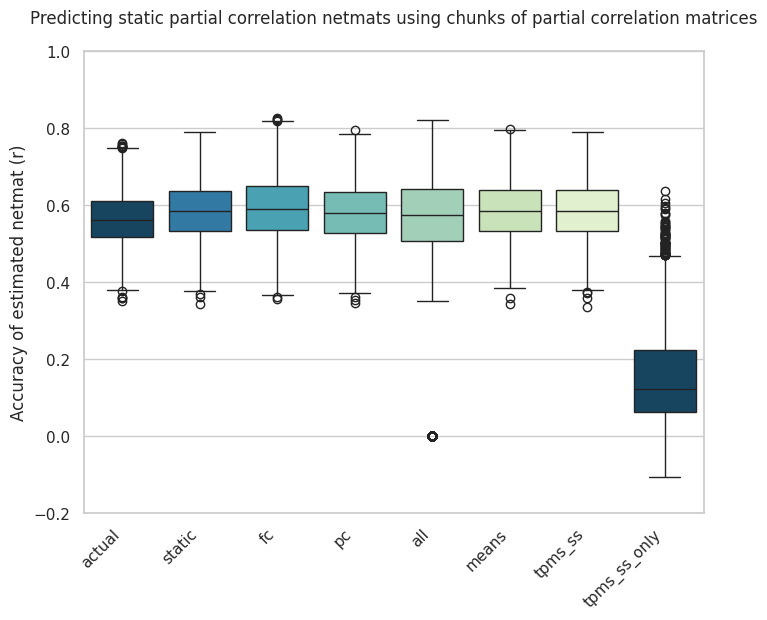

In [399]:
##################### Plot box plots of accuracies across HMM feature groups (across edges)  ########################

# transform array to list to make dataframe to pot as boxplots across edges
hmm_features_accuracy_list = []

for j in range(n_feat_type):
    hmm_features_accuracy_list.append(hmm_features_accuracy[j,:,:].flatten())

print(len(hmm_features_accuracy_list))
print(hmm_features_accuracy_list[0].shape)


# Create a dataframe with the data and group names
df = pd.DataFrame({'Group': np.repeat(labels, [hmm_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
                   'Value': np.concatenate(hmm_features_accuracy_list)})

# Create the grouped boxplot using Seaborn
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd', '#9ad6b8', '#c8e9b3', '#e1f5ca']
#colors = ['#0B486B', '#6bc6bd']
sns.set(style="whitegrid")
#sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('')
plt.ylabel('Accuracy of estimated netmat (r)')

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ymin = -0.2  # Minimum y-value
ymax = 1  # Maximum y-value
ax.set_ylim(ymin, ymax)


# Set the title
plt.title("Predicting static partial correlation netmats using chunks of partial correlation matrices", fontsize=12, pad=20)

# Show the plot
plt.show()

In [376]:
predicted_edges_fc = feature_prediction_dict['fc']['predict_y']
predicted_edges_fc_mean = np.mean(predicted_edges_fc, axis=1)
print(predicted_edges_fc_mean.shape)

print(feature_prediction_dict['fc']['accuracy_per_edge'].shape)
print(predicted_edges_static_mean.shape)
print(predicted_edges_fc_mean.shape)

(12, 300)
